In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from random import shuffle
import tensorflow as tf
import pandas as pd
from sklearn.metrics import roc_auc_score

In [40]:
#HyperParameters
epochs = 50
step_size = 8
IMG_SIZE_ALEXNET = 227 # image size
validating_size = 20 # while cross validating, we are evaluating batch by batch
nodes_fc1 = 4096 # no of nodes on fc layer 1
nodes_fc2 = 4096 # no of nodes on fc layer 2
output_locations = 4 # x1,x2,y1,y2

In [4]:
#Separating train and validation sets
X_train = np.load('object_localization.npy')
y = np.load('object_localization_y.npy')

In [7]:
#data = X_train[:int(len(X_train)*0.1)]
#y =  y[:int(len(y)*0.1)]
data = X_train

In [8]:
#Separating train and validation sets
train = data[:int(len(data)*0.8)]
cv = data[int(len(data)*0.8):]

In [9]:
# X for train input
X = np.array(train)

In [10]:
Y2 = y[:int(len(y)*0.8)]
Y2.shape

(11200, 4)

In [11]:
# cv_x for train input
cv_x = np.array(cv)

In [12]:
cv_y2 = y[int(len(y)*0.8):]
cv_y2.shape

(2800, 4)

In [13]:
#How many training images are kept as 'steps'
steps = len(train)
print(steps)
remaining = steps % step_size

11200


In [14]:
#Resetting graph
tf.reset_default_graph()

In [15]:
#Defining Placeholders
x = tf.placeholder(tf.float32,shape=[None,IMG_SIZE_ALEXNET,IMG_SIZE_ALEXNET,3])
y_true_2 = tf.placeholder(tf.float32,shape=[None,output_locations])

In [16]:
##CONVOLUTION LAYER 1
#Weights for layer 1
w_1 = tf.Variable(tf.truncated_normal([11,11,3,96], stddev=0.01))
#Bias for layer 1
b_1 = tf.Variable(tf.constant(0.0, shape=[[11,11,3,96][3]]))
#Applying convolution
c_1 = tf.nn.conv2d(x, w_1,strides=[1, 4, 4, 1], padding='VALID')
#Adding bias
c_1 = c_1 + b_1
#Applying RELU
c_1 = tf.nn.relu(c_1)
print(c_1)

Tensor("Relu:0", shape=(?, 55, 55, 96), dtype=float32)


In [17]:
##POOLING LAYER1
p_1 = tf.nn.max_pool(c_1, ksize=[1, 3, 3, 1],strides=[1, 2, 2, 1], padding='VALID')
print(p_1)

Tensor("MaxPool:0", shape=(?, 27, 27, 96), dtype=float32)


In [18]:
##CONVOLUTION LAYER 2
#Weights for layer 2
w_2 = tf.Variable(tf.truncated_normal([5,5,96,256], stddev=0.01))
#Bias for layer 2
b_2 = tf.Variable(tf.constant(1.0, shape=[[5,5,96,256][3]]))
#Applying convolution
c_2 = tf.nn.conv2d(p_1, w_2,strides=[1, 1, 1, 1], padding='SAME')
#Adding bias
c_2 = c_2 + b_2
#Applying RELU
c_2 = tf.nn.relu(c_2)
print(c_2)

Tensor("Relu_1:0", shape=(?, 27, 27, 256), dtype=float32)


In [19]:
##POOLING LAYER2
p_2 = tf.nn.max_pool(c_2, ksize=[1, 3, 3, 1],strides=[1, 2, 2, 1], padding='VALID')
print(p_2)

Tensor("MaxPool_1:0", shape=(?, 13, 13, 256), dtype=float32)


In [20]:
##CONVOLUTION LAYER 3
#Weights for layer 3
w_3 = tf.Variable(tf.truncated_normal([3, 3, 256, 384], stddev=0.01))
#Bias for layer 3
b_3 = tf.Variable(tf.constant(0.0, shape=[[3, 3, 256, 384][3]]))
#Applying convolution
c_3 = tf.nn.conv2d(p_2, w_3,strides=[1, 1, 1, 1], padding='SAME')
#Adding bias
c_3 = c_3 + b_3
#Applying RELU
c_3 = tf.nn.relu(c_3)
print(c_3)

Tensor("Relu_2:0", shape=(?, 13, 13, 384), dtype=float32)


In [21]:
##CONVOLUTION LAYER 4
#Weights for layer 4
w_4 = tf.Variable(tf.truncated_normal([3, 3, 384, 384], stddev=0.01))
#Bias for layer 4
b_4 = tf.Variable(tf.constant(0.0, shape=[[3, 3, 384, 384][3]]))
#Applying convolution
c_4 = tf.nn.conv2d(c_3, w_4,strides=[1, 1, 1, 1], padding='SAME')
#Adding bias
c_4 = c_4 + b_4
#Applying RELU
c_4 = tf.nn.relu(c_4)
print(c_4)

Tensor("Relu_3:0", shape=(?, 13, 13, 384), dtype=float32)


In [22]:
##CONVOLUTION LAYER 5
#Weights for layer 5
w_5 = tf.Variable(tf.truncated_normal([3, 3, 384, 256], stddev=0.01))
#Bias for layer 5
b_5 = tf.Variable(tf.constant(0.0, shape=[[3, 3, 384, 256][3]]))
#Applying convolution
c_5 = tf.nn.conv2d(c_4, w_5,strides=[1, 1, 1, 1], padding='SAME')
#Adding bias
c_5 = c_5 + b_5
#Applying RELU
c_5 = tf.nn.relu(c_5)
print(c_5)

Tensor("Relu_4:0", shape=(?, 13, 13, 256), dtype=float32)


In [23]:
##POOLING LAYER3
p_3 = tf.nn.max_pool(c_5, ksize=[1, 3, 3, 1],strides=[1, 2, 2, 1], padding='VALID')
print(p_3)

Tensor("MaxPool_2:0", shape=(?, 6, 6, 256), dtype=float32)


In [24]:
#Flattening
flattened = tf.reshape(p_3,[-1,6*6*256])
print(flattened)

Tensor("Reshape:0", shape=(?, 9216), dtype=float32)


In [25]:
##Fully Connected Layer 1
#Getting input nodes in FC layer 1
input_size = int( flattened.get_shape()[1] )
#Weights for FC Layer 1
w1_fc = tf.Variable(tf.truncated_normal([input_size, nodes_fc1], stddev=0.01))
#Bias for FC Layer 1
b1_fc = tf.Variable( tf.constant(1.0, shape=[nodes_fc1] ) )
#Summing Matrix calculations and bias
s_fc1 = tf.matmul(flattened, w1_fc) + b1_fc
#Applying RELU
s_fc1 = tf.nn.relu(s_fc1)

In [26]:
#Dropout Layer 1
hold_prob1 = tf.placeholder(tf.float32)
s_fc1 = tf.nn.dropout(s_fc1,keep_prob=hold_prob1)
print(s_fc1)

Tensor("dropout/mul:0", shape=(?, 4096), dtype=float32)


In [27]:
##Fully Connected Layer 2
#Weights for FC Layer 2
w2_fc = tf.Variable(tf.truncated_normal([nodes_fc1, nodes_fc2], stddev=0.01))
#Bias for FC Layer 2
b2_fc = tf.Variable( tf.constant(1.0, shape=[nodes_fc2] ) )
#Summing Matrix calculations and bias
s_fc2 = tf.matmul(s_fc1, w2_fc) + b2_fc
#Applying RELU
s_fc2 = tf.nn.relu(s_fc2)
print(s_fc2)

Tensor("Relu_6:0", shape=(?, 4096), dtype=float32)


In [28]:
#Dropout Layer 2
hold_prob2 = tf.placeholder(tf.float32)
s_fc2 = tf.nn.dropout(s_fc2,keep_prob=hold_prob2)

In [29]:
##Fully Connected Layer 3 -- REGRESSION HEAD
#Weights for FC Layer 3
w3_fc_2 = tf.Variable(tf.truncated_normal([nodes_fc2,output_locations], stddev=0.01))
#Bias for FC Layer 3b3_fc = tf.Variable( tf.constant(1.0, shape=[output_classes] ) )
b3_fc_2 = tf.Variable( tf.constant(1.0, shape=[output_locations] ) )
#Summing Matrix calculations and bias
y_pred_2 = tf.matmul(s_fc2, w3_fc_2) + b3_fc_2
#Applying RELU
print(y_pred_2)

Tensor("add_7:0", shape=(?, 4), dtype=float32)


In [30]:
#Defining Regression Loss
regression_loss = tf.multiply(tf.reduce_mean(tf.square(y_pred_2 - y_true_2)),1.0)

In [31]:
final_loss = regression_loss

In [32]:
#Defining objective
train = tf.train.AdamOptimizer(learning_rate=0.00001).minimize(final_loss)

In [33]:
#Initializing weights
init = tf.global_variables_initializer()

In [34]:
#Starting Empty lists to keep results
regression_list = []
#In order to save, creating a tf.train.Saver() object.
saver = tf.train.Saver()

In [35]:
#GPU settings
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True
config.gpu_options.allocator_type = 'BFC'

tf.add_to_collection("regression_head", y_pred_2)

In [41]:
def main():
    with tf.Session(config=config) as sess:
        sess.run(init)
        for i in range(epochs):
            total_cost = 0
            for j in range(0,steps-remaining,step_size):
                #Feeding step_size-amount data with 0.5 keeping probabilities on DROPOUT LAYERS
                _,c = sess.run([train,final_loss],feed_dict = {x:X[j:j+step_size], y_true_2:Y2[j:j+step_size],hold_prob1:0.5,hold_prob2:0.5})
                total_cost += c
            print(total_cost)
#Writing for loop to calculate test statistics. GTX 1060 isn't able to calculate all cv data.
            cv_regression_list = []
            for v in range(0,len(cv_x)-int(len(cv_x) % validating_size),validating_size):
                coordinates = sess.run([y_pred_2],feed_dict={x:cv_x[v:v+validating_size],hold_prob1:1.0,hold_prob2:1.0})
                regression_loss = np.mean(pow(cv_y2[v:v+validating_size] - coordinates , 2 ) )
                cv_regression_list.append(regression_loss)
            regression_loss_cv_ = round(np.mean(cv_regression_list),5)
            regression_list.append(regression_loss_cv_)
        print("Training has finished and model is saved")
        saver.save(sess, os.path.join(os.getcwd(),"CNN_OL.ckpt"))

if __name__ == "__main__":
    main()

1474499.5658569336
627809.1913452148
508112.57054901123
428395.6546783447
379812.496635437
334404.41690444946
308646.5739021301
282958.99739456177
263954.7058753967
247732.78867340088
231858.25890731812
214974.15214538574
206093.64211082458
192963.6032371521
179990.42989349365
170521.71319580078
160373.64823532104
149111.51332855225
142644.585313797
135919.03146362305
128074.91137695312
119932.44240188599
113466.24801826477
107740.67350578308
102017.11066246033
98372.12483215332
93539.93515968323
90018.04765319824
85151.19720840454
83023.96082496643
79361.05266952515
76693.96469116211
76115.68497085571
72318.4828453064
70184.86773586273
67503.65877532959
65925.42791748047
64064.69755268097
62152.41176986694
61604.7987909317
60606.467604637146
57591.569725990295
57289.365436553955
56239.35310745239
55973.42277622223
54156.65759754181
52816.03158378601
51609.32807350159
51217.76379585266
49719.213240623474
Training has finished and model is saved


In [42]:
test_photos = X_train[0:100]

In [43]:
from PIL import Image
import matplotlib.patches as patches
with tf.Session() as session:
    new_saver = tf.train.Saver()
    new_saver.restore(session, "CNN_OL.ckpt")
    print("Model restored.") 
    print('Initialized')
    l = session.run([y_pred_2], feed_dict={x: test_photos, hold_prob1:1,hold_prob2:1})
    print(l[0].shape)

INFO:tensorflow:Restoring parameters from CNN_OL.ckpt
Model restored.
Initialized
(100, 4)


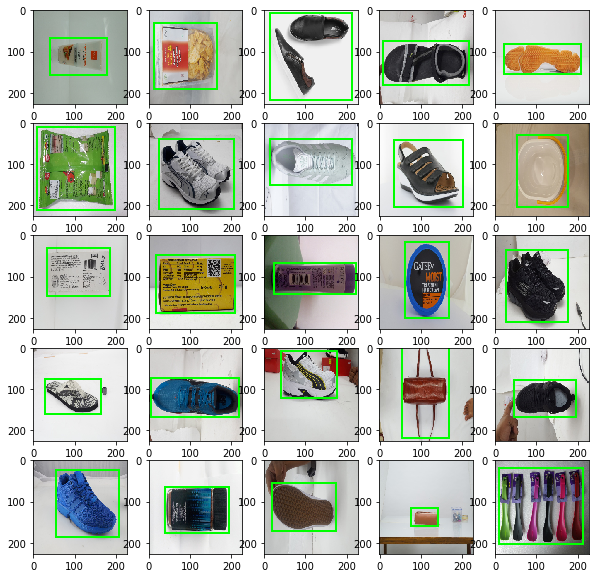

Testing finished


In [44]:
# in order to modify the size
fig = plt.figure(figsize = (10,10))
for m in range(25):
    ax = fig.add_subplot(5,5,m+1)
    img = test_photos[m].reshape([IMG_SIZE_ALEXNET, IMG_SIZE_ALEXNET, 3])
    # Display the image
    ax.imshow(img)
    # Create a Rectangle patch
    rect = patches.Rectangle((l[0][m][0],l[0][m][2]),l[0][m][1]-l[0][m][0],l[0][m][3]-l[0][m][2],linewidth=2,edgecolor='lime',facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
plt.show()
print("Testing finished")